# Load Dataset

We download the dataset containing images of leaves and plants and the label files containing the coordinates of the boxes of each plant

In [49]:
!git clone https://github.com/Bottins/Leaf_dataset.git

fatal: destination path 'Leaf_dataset' already exists and is not an empty directory.


# Auxiliary
To effectively address this problem, it is essential to incorporate several key libraries into the current project. These libraries will provide the necessary tools and functionality to implement the required solution efficiently.

In [51]:
# Pip install method (recommended)
!pip install ultralytics
!pip install squarify

import csv
import keras as keras
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import shutil
import squarify
import cv2
import matplotlib.image as mpimg
import seaborn as sns
import sklearn
import ultralytics
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
sns.set_style('darkgrid')
# Reproducibility
import tensorflow as tf
random_seed = 42
random.seed(random_seed)
%matplotlib inline

In [52]:
def csv_to_dataframe(csv_filepath, columns_name):
    df = pd.read_csv(csv_filepath, names=columns_name, header=0)
    return df

def calc_percentage(df_total, df_part,file_id_column):
    part = len(df_part[file_id_column].unique())
    total = len(df_total[file_id_column].unique())
    return (part / total) * 100

def dict_to_yaml(data):
    yaml_lines = []
    for key, value in data.items():
        if key == 'format':
            if value == 'line_break':
                 yaml_lines.append('')
        elif isinstance(value, list):
            yaml_lines.append(f"{key}: {value}")
        else:
            yaml_lines.append(f"{key}: {value}")
    return '\n'.join(yaml_lines)

def create_yaml_data(yaml_file_name,output_dir,data):
    yaml_content = dict_to_yaml(data)
    output_path = os.path.join(output_dir, f'{yaml_file_name}.yaml')
    os.makedirs(output_dir, exist_ok=True)
    with open(output_path, 'w') as file:
        file.write(yaml_content)
    print(f'YAML file created successfully in {output_path}.')

def convert_bbox_to_yolo(x, y, width, height, img_width, img_height):
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width /= img_width
    height /= img_height
    return x_center, y_center, width, height

def dataframe_yolofiles(df, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    data = {}
    for index, row in df.iterrows():
        image_id = row['image_id']
        img_width = int(row['width'])
        img_height = int(row['height'])
        bbox = eval(row['bbox'])
        x, y, width, height = bbox
        x_center, y_center, norm_width, norm_height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)
        if image_id not in data:
            data[image_id] = []
        data[image_id].append(f"0 {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    for image_id, bboxes in data.items():
        output_file_path = os.path.join(output_dir, os.path.splitext(image_id)[0] + ".txt")
        with open(output_file_path, 'w') as f:
            for bbox in bboxes:
                f.write(bbox + "\n")
    print(f'Total text files created in: {output_dir}')

def move_images_to_directory(df, root_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    unique_image_ids = df['image_id'].unique()
    for image_id in unique_image_ids:
        source_path = os.path.join(root_dir, image_id)
        target_path = os.path.join(target_dir, image_id)
        if os.path.exists(source_path):
            shutil.copy(source_path, target_path)
        else:
            print(f"Warning: Image {image_id} not found on path {source_path}")
    print(f'Total images moved to: {target_dir}')

def leaf_detect(img_path,model):
    img = cv2.imread(img_path)
    detect_result = model(img)
    detect_img = detect_result[0].plot()
    detect_img = cv2.cvtColor(detect_img, cv2.COLOR_BGR2RGB)
    return detect_img

def plot_images_with_detections(images_dir, labels_dir, num_images=16, grid_size=(4, 4), figsize=(16, 16)):
    image_files = os.listdir(images_dir)
    image_files.sort()
    images_forshow = image_files[:num_images]
    fig, axs = plt.subplots(grid_size[0], grid_size[1], figsize=figsize)
    for i, image_file in enumerate(images_forshow):
        row = i // grid_size[1]
        col = i % grid_size[1]
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        label_file = os.path.splitext(image_file)[0] + ".txt"
        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, "r") as f:
            labels = f.read().strip().split("\n")
        for label in labels:
            if len(label.split()) != 5:
                continue
            class_id, x_center, y_center, width, height = map(float, label.split())
            x_min = int((x_center - width / 2) * image.shape[1])
            y_min = int((y_center - height / 2) * image.shape[0])
            x_max = int((x_center + width / 2) * image.shape[1])
            y_max = int((y_center + height / 2) * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (250, 221, 47), 3)
        axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axs[row, col].axis('off')
    plt.show()

def show_csv_results(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 15))
    sns.lineplot(x='epoch', y='train/box_loss', data=df, ax=axs[0,0])
    sns.lineplot(x='epoch', y='train/cls_loss', data=df, ax=axs[0,1])
    sns.lineplot(x='epoch', y='train/dfl_loss', data=df, ax=axs[1,0])
    sns.lineplot(x='epoch', y='metrics/precision(B)', data=df, ax=axs[1,1])
    sns.lineplot(x='epoch', y='metrics/recall(B)', data=df, ax=axs[2,0])
    sns.lineplot(x='epoch', y='metrics/mAP50(B)', data=df, ax=axs[2,1])
    sns.lineplot(x='epoch', y='metrics/mAP50-95(B)', data=df, ax=axs[3,0])
    sns.lineplot(x='epoch', y='val/box_loss', data=df, ax=axs[3,1])
    sns.lineplot(x='epoch', y='val/cls_loss', data=df, ax=axs[4,0])
    sns.lineplot(x='epoch', y='val/dfl_loss', data=df, ax=axs[4,1])
    axs[0,0].set(title='Train Box Loss')
    axs[0,1].set(title='Train Class Loss')
    axs[1,0].set(title='Train DFL Loss')
    axs[1,1].set(title='Metrics Precision (B)')
    axs[2,0].set(title='Metrics Recall (B)')
    axs[2,1].set(title='Metrics mAP50 (B)')
    axs[3,0].set(title='Metrics mAP50-95 (B)')
    axs[3,1].set(title='Validation Box Loss')
    axs[4,0].set(title='Validation Class Loss')
    axs[4,1].set(title='Validation DFL Loss')
    plt.suptitle('Training Metrics and Loss', fontsize=24)
    plt.subplots_adjust(top=0.8)
    plt.tight_layout()
    plt.show()

def show_directory_images(directory, num_images, rows=3, columns=3):
    archivos_imagen = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    fig = plt.figure(figsize=(10, 10))
    for i in range(min(num_images, len(archivos_imagen))):
        img_path = os.path.join(directory, archivos_imagen[i])
        img = cv2.imread(img_path)
        ax = fig.add_subplot(rows, columns, i + 1)
        ax.imshow(img)
        ax.axis('off')
    for j in range(num_images, rows * columns):
        ax = fig.add_subplot(rows, columns, j + 1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

def show_metrics(metrics):
    # Create the barplot
    ax = sns.barplot(x=['mAP50-95', 'mAP50', 'mAP75'], y=[metrics.box.map, metrics.box.map50, metrics.box.map75])
    # Set the title and axis labels
    ax.set_title('YOLO Evaluation Metrics')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Value')
    # Set the figure size
    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    # Add the values on top of the bars
    for p in ax.patches:
        ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    # Show the plot
    plt.show()

def show_detections(images_dir, num_images=16, rows=4, columns=4):
    image_files = os.listdir(images_dir)
    selected_images = random.sample(image_files, num_images)
    fig, axes = plt.subplots(nrows=rows, ncols=columns, figsize=(15, 15))
    for i, img_file in enumerate(selected_images):
        row_idx = i // columns
        col_idx = i % columns
        img_path = os.path.join(images_dir, img_file)
        detect_img = leaf_detect(img_path, model)
        axes[row_idx, col_idx].imshow(detect_img)
        axes[row_idx, col_idx].axis('off')
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()

def show_image(img_path):
    img = mpimg.imread(img_path)
    fig, ax = plt.subplots(figsize = (15, 15))
    ax.imshow(img)
    ax.axis('off')
    plt.show()

# Train Dataset
Let's organize the dataset into three distinct subfolders: **Train**, **Validation**, and **Test**.
1. The **Train** folder will contain the data used to train the model, ensuring it learns the underlying patterns and relationships.
2. The **Validation** folder will be used to tune hyperparameters and evaluate the model's performance during training, helping to prevent overfitting.
3. Finally, the **Test** folder will hold the data reserved for assessing the model’s performance after training, providing an unbiased evaluation of its generalization capabilities. This structured approach ensures a clear separation of data for each phase of the machine learning pipeline.

In [53]:
columns_name = ['image_id', 'width', 'height', 'bbox']
csv_filepath = '/content/Leaf_dataset/Leaf/train.csv'
annotations = csv_to_dataframe(csv_filepath,columns_name)
df = pd.DataFrame(annotations)

# Split the DataFrame into training(80%) and validation with test(20%) based on the unique file names
unique_filenames = df['image_id'].unique()
train_filenames, val_test_filenames = train_test_split(unique_filenames, test_size=0.2, random_state=random_seed)
train_df = df[df['image_id'].isin(train_filenames)]

# 10% for validation and 10% for test
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size=0.5, random_state=random_seed)
val_df = df[df['image_id'].isin(val_filenames)]
test_df = df[df['image_id'].isin(test_filenames)]

# Yolo Configuration


1. **YAML File Creation:**
Creating a YAML configuration file to define dataset paths and model settings.

2. **Path Declaration:**
Specifying file and directory paths for the dataset and model components.

3. **Viewing Uploaded Files:**
Inspecting the uploaded files to ensure proper structure and readiness for training.



In [65]:
import os
output_dir = '/content/working/yolo_dataset_leafdetection'
yaml_file_name = 'data'
yaml_data = {
    'train': f'{output_dir}/train/images',
    'val': f'{output_dir}/valid/images',
    'test': f'{output_dir}/test/images',
    'format':'line_break',
    'nc': 1,
    'names': ['leaf']
}

create_yaml_data(yaml_file_name,output_dir,yaml_data)

YAML file created successfully in /content/working/yolo_dataset_leafdetection/data.yaml.


Total images moved to: /content/working/yolo_dataset_leafdetection/train/images
Total text files created in: /content/working/yolo_dataset_leafdetection/train/labels
Total images moved to: /content/working/yolo_dataset_leafdetection/valid/images
Total text files created in: /content/working/yolo_dataset_leafdetection/valid/labels
Total images moved to: /content/working/yolo_dataset_leafdetection/test/images
Total text files created in: /content/working/yolo_dataset_leafdetection/test/labels


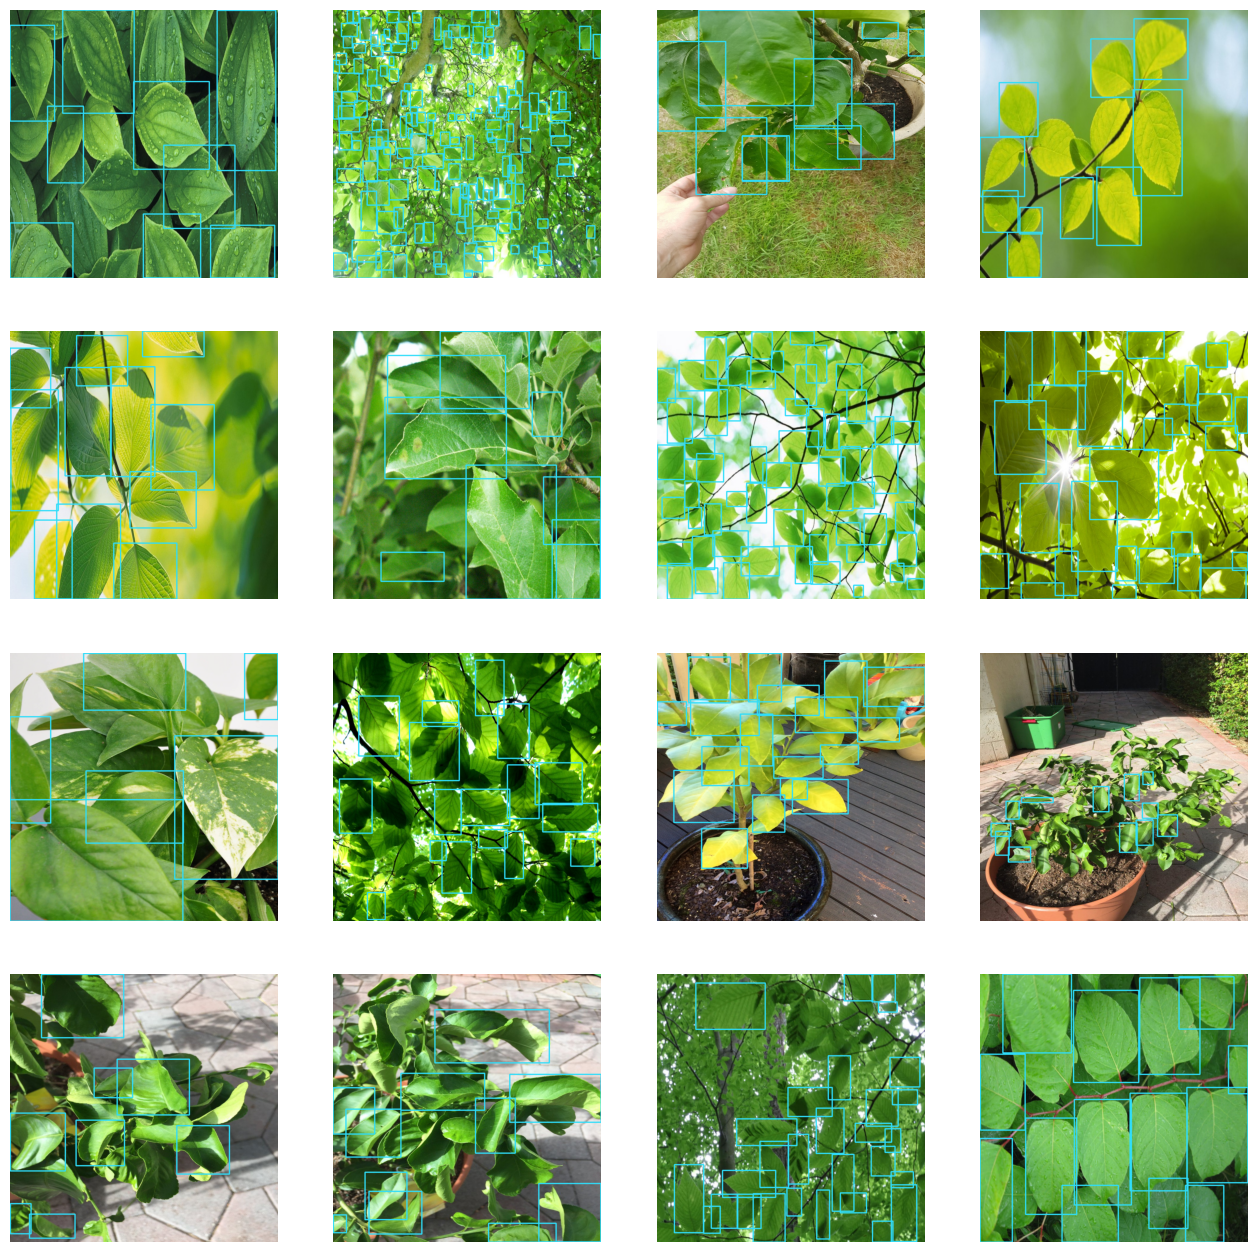

The image has dimensions 1024x1024 and 3 channels.


In [66]:
paths_all_images = '/content/Leaf_dataset/Leaf/train/'

# Data for train
txt_files_train = f'{output_dir}/train/labels'
img_files_train = f'{output_dir}/train/images'
move_images_to_directory(train_df, paths_all_images, img_files_train)
dataframe_yolofiles(train_df, txt_files_train)

# Data for validation
txt_files_val = f'{output_dir}/valid/labels'
img_files_val = f'{output_dir}/valid/images'
move_images_to_directory(val_df, paths_all_images, img_files_val)
dataframe_yolofiles(val_df, txt_files_val)

# Data for test
txt_files_test = f'{output_dir}/test/labels'
img_files_test = f'{output_dir}/test/images'
move_images_to_directory(test_df, paths_all_images, img_files_test)
dataframe_yolofiles(test_df, txt_files_test)

# Define the paths to the images and labels directories
train_images = "/content/working/yolo_dataset_leafdetection/train/images"
train_labels = "/content/working/yolo_dataset_leafdetection/train/labels"

test_images = "/content/working/yolo_dataset_leafdetection/test/images"
test_labels = "/content/working/yolo_dataset_leafdetection/test/labels"

val_images = "/content/working/yolo_dataset_leafdetection/valid/images"
val_labels = "/content/working/yolo_dataset_leafdetection/valid/labels"

plot_images_with_detections(train_images, train_labels)

# Load an image using OpenCV
image = cv2.imread("/content/working/yolo_dataset_leafdetection/train/images/LEAF_1171.jpg")

# Get the size of the image
height, width, channels = image.shape
print(f"The image has dimensions {width}x{height} and {channels} channels.")

# Load Pre-trained Model
Once the pre-trained weights are successfully downloaded, the model is deployed to evaluate the images in the test folder. This step allows us to assess the model's ability to generalize to new, unseen data, providing a critical evaluation of its performance in real-world scenarios. By running inference on the test set, we can obtain valuable metrics that reflect the model’s accuracy, precision, and overall effectiveness in solving the task at hand.

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading /content/Leaf_dataset/Leaf/model/best_float32.tflite for TensorFlow Lite inference...

image 1/7 /content/Leaf_dataset/Leaf/test/leaf/TEST_001.jpg: 1024x1024 101 leafs, 449.9ms
image 2/7 /content/Leaf_dataset/Leaf/test/leaf/TEST_002.jpg: 1024x1024 165 leafs, 427.2ms
image 3/7 /content/Leaf_dataset/Leaf/test/leaf/TEST_003.jpg: 1024x1024 16 leafs, 462.6ms
image 4/7 /content/Leaf_dataset/Leaf/test/leaf/TEST_004.jpg: 1024x1024 76 leafs, 425.5ms
image 5/7 /content/Leaf_dataset/Leaf/test/leaf/TEST_005.jpg: 1024x1024 87 leafs, 446.8ms
image 6/7 /content/Leaf_dataset/Leaf/test/leaf/TEST_006.jpg: 1024x1024 4 leafs, 445.0ms
image 7/7 /content/Leaf_dataset/Leaf/test/leaf/TEST_007.jpg: 1024x1024 27 leafs, 459.1ms
Speed: 6.2ms preprocess, 445.2ms inference, 1.6ms postprocess per image at shape (1, 3, 1024, 1024)
Result

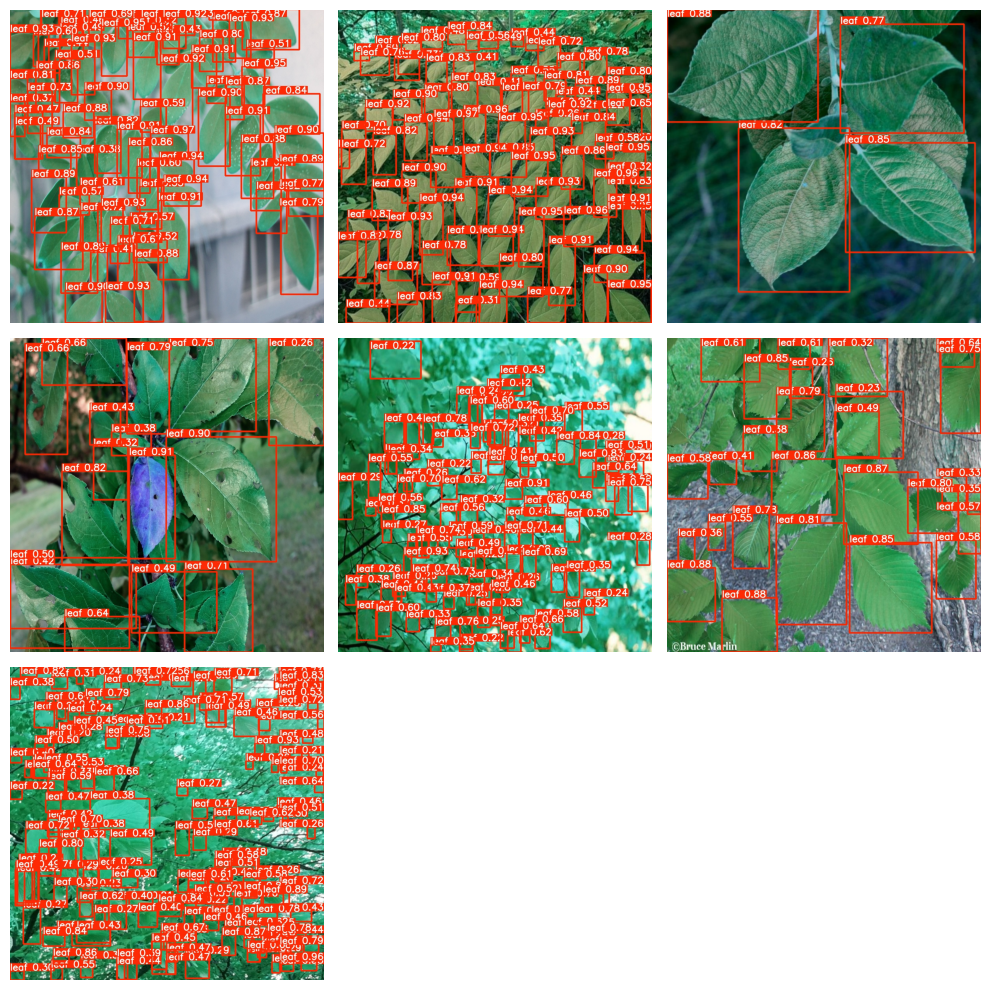

In [63]:
# Load a pretrained YOLOv8n model
model = YOLO('/content/Leaf_dataset/Leaf/model/best_float32.tflite')

#Remove existing Predict folder
import shutil
output_dir = '/content/runs/detect/predict'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
# Run inference
model.predict('/content/Leaf_dataset/Leaf/test/leaf', save=True,save_txt=True, imgsz=1024, conf=0.2)
images_dir = '/content/runs/detect/predict'
num_images = 7
show_directory_images(images_dir, num_images)

# CSV Export
In this section, we export the model's predictions a to a CSV file. This allows for easy analysis and documentation of results, including image IDs, predicted labels number, height , width.

In [64]:
import os
import pandas as pd


# Percorso delle immagini e dei file TXT generati dal modello
image_dir = '/content/Leaf_dataset/Leaf/test/leaf'  # Percorso immagini
label_dir = '/content/runs/detect/predict/labels'  # File TXT con bounding box
output_csv = '/content/detection_summary.csv'  # Percorso per il CSV

# Funzione per calcolare larghezza e altezza delle immagini
def get_image_dimensions(image_path):
    from PIL import Image
    with Image.open(image_path) as img:
        return img.width, img.height

# Inizializza una lista per raccogliere i risultati
summary_data = []

# Elabora ciascun file di label
for label_file in os.listdir(label_dir):
    image_id = label_file.replace('.txt', '')
    image_path = os.path.join(image_dir, f"{image_id}.jpg")
    if not os.path.exists(image_path):
        continue

    # Ottieni le dimensioni dell'immagine
    img_width, img_height = get_image_dimensions(image_path)

    # Carica i bounding box
    bboxes = []
    with open(os.path.join(label_dir, label_file), 'r') as f:
        for line in f:
            parts = line.strip().split()
            x_center, y_center, width, height = map(float, parts[1:])

            # Converti a coordinate assolute
            xmin = (x_center - width / 2) * img_width
            ymin = (y_center - height / 2) * img_height
            xmax = (x_center + width / 2) * img_width
            ymax = (y_center + height / 2) * img_height
            bboxes.append((xmin, ymin, xmax, ymax))

    # Se non ci sono rilevazioni, salta l'immagine
    if not bboxes:
        continue

    # Calcola altezza (max_y - min_y) e larghezza (max_x - min_x)
    xmin = min(b[0] for b in bboxes)
    ymin = min(b[1] for b in bboxes)
    xmax = max(b[2] for b in bboxes)
    ymax = max(b[3] for b in bboxes)
    H = round(ymax - ymin,2)
    W = round(xmax - xmin,2)

    # Aggiungi i risultati al dataset
    summary_data.append([image_id, len(bboxes), H, W])

# Crea il DataFrame e salva come CSV
columns = ['image_id', 'numero_rilevazioni', 'altezza', 'larghezza']
df = pd.DataFrame(summary_data, columns=columns)
df.to_csv(output_csv, index=False)

print(f"File CSV creato: {output_csv}")


File CSV creato: /content/detection_summary.csv


# Behind the scenes

The following sections are designed for users who wish to independently train the model, allowing them to customize the dataset, adjust hyperparameters, or fine-tune the model to better suit their specific requirements and objectives. This flexibility provides the opportunity for more advanced configurations and optimizations tailored to particular use cases.

In [ ]:
# Loading a pretrained model
model = YOLO('yolov8n.pt')

# Training the model
model.train(data = '/content/working/yolo_dataset_leafdetection/data.yaml',
            epochs = 50,
            imgsz = height,
            seed = random_seed,
            batch = 8,
            workers = 4)

100%|██████████| 6.25M/6.25M [00:00<00:00, 126MB/s]


Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/working/yolo_dataset_leafdetection/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

100%|██████████| 755k/755k [00:00<00:00, 21.9MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 86.7MB/s]


AMP: checks passed ✅


train: Scanning /content/working/yolo_dataset_leafdetection/train/labels... 904 images, 0 backgrounds, 0 corrupt: 100%|██████████| 904/904 [00:00<00:00, 1679.73it/s]

train: New cache created: /content/working/yolo_dataset_leafdetection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/working/yolo_dataset_leafdetection/valid/labels... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<00:00, 1016.11it/s]

val: New cache created: /content/working/yolo_dataset_leafdetection/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50       4.7G      1.483      2.387      1.767         50       1024: 100%|██████████| 113/113 [00:43<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

                   all        113        532      0.395      0.442      0.365      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.21G      1.498      2.092      1.765         67       1024: 100%|██████████| 113/113 [00:40<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.63it/s]

                   all        113        532      0.438      0.316       0.31      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.85G      1.519      1.982       1.81         41       1024: 100%|██████████| 113/113 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.34it/s]


                   all        113        532      0.363      0.434      0.332      0.173

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.59G      1.528      1.872      1.805         59       1024: 100%|██████████| 113/113 [00:41<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

                   all        113        532      0.437      0.441      0.396      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.56G      1.545      1.805      1.824        111       1024: 100%|██████████| 113/113 [00:39<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.92it/s]

                   all        113        532      0.409      0.378      0.336      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.55G      1.487      1.714      1.761         63       1024: 100%|██████████| 113/113 [00:41<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]


                   all        113        532      0.427      0.455      0.405       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.91G       1.47      1.677       1.73         38       1024: 100%|██████████| 113/113 [00:38<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]

                   all        113        532       0.49       0.47      0.443      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.72G       1.45      1.637      1.742         38       1024: 100%|██████████| 113/113 [00:39<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.37it/s]

                   all        113        532      0.522      0.509      0.467      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.73G      1.428      1.612      1.722         68       1024: 100%|██████████| 113/113 [00:40<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]

                   all        113        532      0.553      0.466      0.491      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.13G      1.409      1.539      1.703        101       1024: 100%|██████████| 113/113 [00:39<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.31it/s]

                   all        113        532      0.372      0.408      0.361      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       3.5G       1.38      1.503      1.692         56       1024: 100%|██████████| 113/113 [00:40<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.49it/s]

                   all        113        532      0.545      0.504        0.5      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.62G      1.385      1.477      1.685        162       1024: 100%|██████████| 113/113 [00:39<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.21it/s]

                   all        113        532      0.523      0.491      0.441      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.02G       1.38      1.483       1.67         41       1024: 100%|██████████| 113/113 [00:39<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.64it/s]

                   all        113        532      0.507      0.509      0.487      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.28G      1.366      1.478      1.664        132       1024: 100%|██████████| 113/113 [00:39<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]

                   all        113        532      0.521      0.534      0.502      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.58G      1.352       1.41      1.637         68       1024: 100%|██████████| 113/113 [00:40<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.17it/s]

                   all        113        532      0.562      0.509      0.539      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.78G      1.322      1.412      1.635         61       1024: 100%|██████████| 113/113 [00:40<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.24it/s]


                   all        113        532       0.52       0.57      0.539      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.62G      1.329      1.378      1.632         42       1024: 100%|██████████| 113/113 [00:39<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

                   all        113        532      0.568      0.494      0.508      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.23G      1.321      1.397      1.634         62       1024: 100%|██████████| 113/113 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.59it/s]

                   all        113        532      0.597       0.47       0.52      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.19G      1.313      1.341      1.613         57       1024: 100%|██████████| 113/113 [00:41<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.17it/s]

                   all        113        532       0.49       0.56      0.525      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.25G      1.298      1.331      1.591         32       1024: 100%|██████████| 113/113 [00:38<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.83it/s]

                   all        113        532      0.514      0.562      0.554      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         3G      1.272      1.291      1.601         67       1024: 100%|██████████| 113/113 [00:41<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]

                   all        113        532      0.589      0.545      0.579      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.77G      1.284      1.292      1.587         77       1024: 100%|██████████| 113/113 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.76it/s]

                   all        113        532      0.545      0.524      0.552      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50       3.7G      1.262      1.267       1.59         37       1024: 100%|██████████| 113/113 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]


                   all        113        532       0.52      0.605      0.544      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.03G      1.263      1.281       1.57         42       1024: 100%|██████████| 113/113 [00:39<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]

                   all        113        532      0.608      0.552      0.577      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.34G      1.203      1.197      1.529         47       1024: 100%|██████████| 113/113 [00:39<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]

                   all        113        532      0.529      0.615      0.577      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.98G      1.224      1.204      1.528         53       1024: 100%|██████████| 113/113 [00:42<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

                   all        113        532      0.567      0.571      0.581      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50       3.8G      1.264      1.225      1.558         50       1024: 100%|██████████| 113/113 [00:39<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

                   all        113        532      0.547      0.598      0.578      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.75G      1.234       1.22      1.549         57       1024: 100%|██████████| 113/113 [00:41<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.48it/s]

                   all        113        532      0.556      0.541      0.566      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.08G      1.191      1.154      1.515         90       1024: 100%|██████████| 113/113 [00:40<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

                   all        113        532       0.57      0.581      0.581      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.49G      1.211       1.19      1.535         66       1024: 100%|██████████| 113/113 [00:39<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]

                   all        113        532      0.599      0.586      0.592      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.69G      1.201      1.187      1.534         55       1024: 100%|██████████| 113/113 [00:41<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]

                   all        113        532      0.567      0.538      0.563      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.12G      1.175      1.116      1.485         38       1024: 100%|██████████| 113/113 [00:40<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.31it/s]

                   all        113        532       0.53      0.645      0.576      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.94G      1.193      1.121      1.514         37       1024: 100%|██████████| 113/113 [00:42<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.28it/s]

                   all        113        532      0.548      0.564      0.557      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.09G      1.158      1.115      1.476         72       1024: 100%|██████████| 113/113 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

                   all        113        532      0.545      0.617      0.579       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.47G      1.176      1.135      1.497         44       1024: 100%|██████████| 113/113 [00:40<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

                   all        113        532      0.546       0.63      0.602      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.81G      1.151      1.108      1.487         76       1024: 100%|██████████| 113/113 [00:41<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]

                   all        113        532      0.581      0.555      0.569      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.28G       1.14      1.081      1.444         58       1024: 100%|██████████| 113/113 [00:39<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.96it/s]

                   all        113        532      0.541       0.62      0.581       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.03G      1.129       1.06      1.457         71       1024: 100%|██████████| 113/113 [00:42<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.35it/s]

                   all        113        532      0.551      0.658      0.601      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.87G      1.133      1.038       1.45         61       1024: 100%|██████████| 113/113 [00:40<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]

                   all        113        532      0.573      0.602      0.581      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.22G      1.125      1.035      1.451         53       1024: 100%|██████████| 113/113 [00:39<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.32it/s]

                   all        113        532      0.604      0.606      0.615      0.373


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50       3.7G      1.131      1.019      1.466         33       1024: 100%|██████████| 113/113 [00:41<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        113        532      0.574      0.658      0.636      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.49G      1.106     0.9896      1.469         20       1024: 100%|██████████| 113/113 [00:37<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]

                   all        113        532      0.552      0.624       0.61       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.43G      1.082     0.9481      1.447         26       1024: 100%|██████████| 113/113 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.39it/s]

                   all        113        532      0.598      0.581      0.598      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.78G      1.076     0.9519       1.44         33       1024: 100%|██████████| 113/113 [00:37<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]

                   all        113        532      0.635      0.568      0.621      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.78G      1.058     0.9154      1.433         13       1024: 100%|██████████| 113/113 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.22it/s]

                   all        113        532      0.597      0.633       0.63      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.73G      1.053     0.9275      1.432         29       1024: 100%|██████████| 113/113 [00:37<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        113        532      0.575      0.641      0.629        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.48G      1.041     0.9083        1.4         74       1024: 100%|██████████| 113/113 [00:38<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.75it/s]

                   all        113        532      0.596      0.633      0.632      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.81G      1.024     0.8868      1.409         47       1024: 100%|██████████| 113/113 [00:38<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

                   all        113        532      0.565      0.699       0.64      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50       3.6G      1.026     0.8683      1.397         42       1024: 100%|██████████| 113/113 [00:38<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.07it/s]

                   all        113        532      0.581       0.66      0.651      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.37G      1.009     0.8571      1.384         38       1024: 100%|██████████| 113/113 [00:38<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.25it/s]

                   all        113        532      0.557      0.673      0.644      0.402



50 epochs completed in 0.607 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


                   all        113        532      0.581       0.66      0.651      0.407
Speed: 0.8ms preprocess, 6.5ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e1afb38eaa0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Evaluating the model on the test dataset
metrics = model.val(conf = 0.25, split = 'test')

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/working/yolo_dataset_leafdetection/test/labels... 113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 113/113 [00:00<00:00, 2039.62it/s]

val: New cache created: /content/working/yolo_dataset_leafdetection/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:05<00:00,  2.84it/s]


                   all        113        626      0.684      0.709        0.7      0.483
Speed: 2.3ms preprocess, 14.7ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to runs/detect/train2


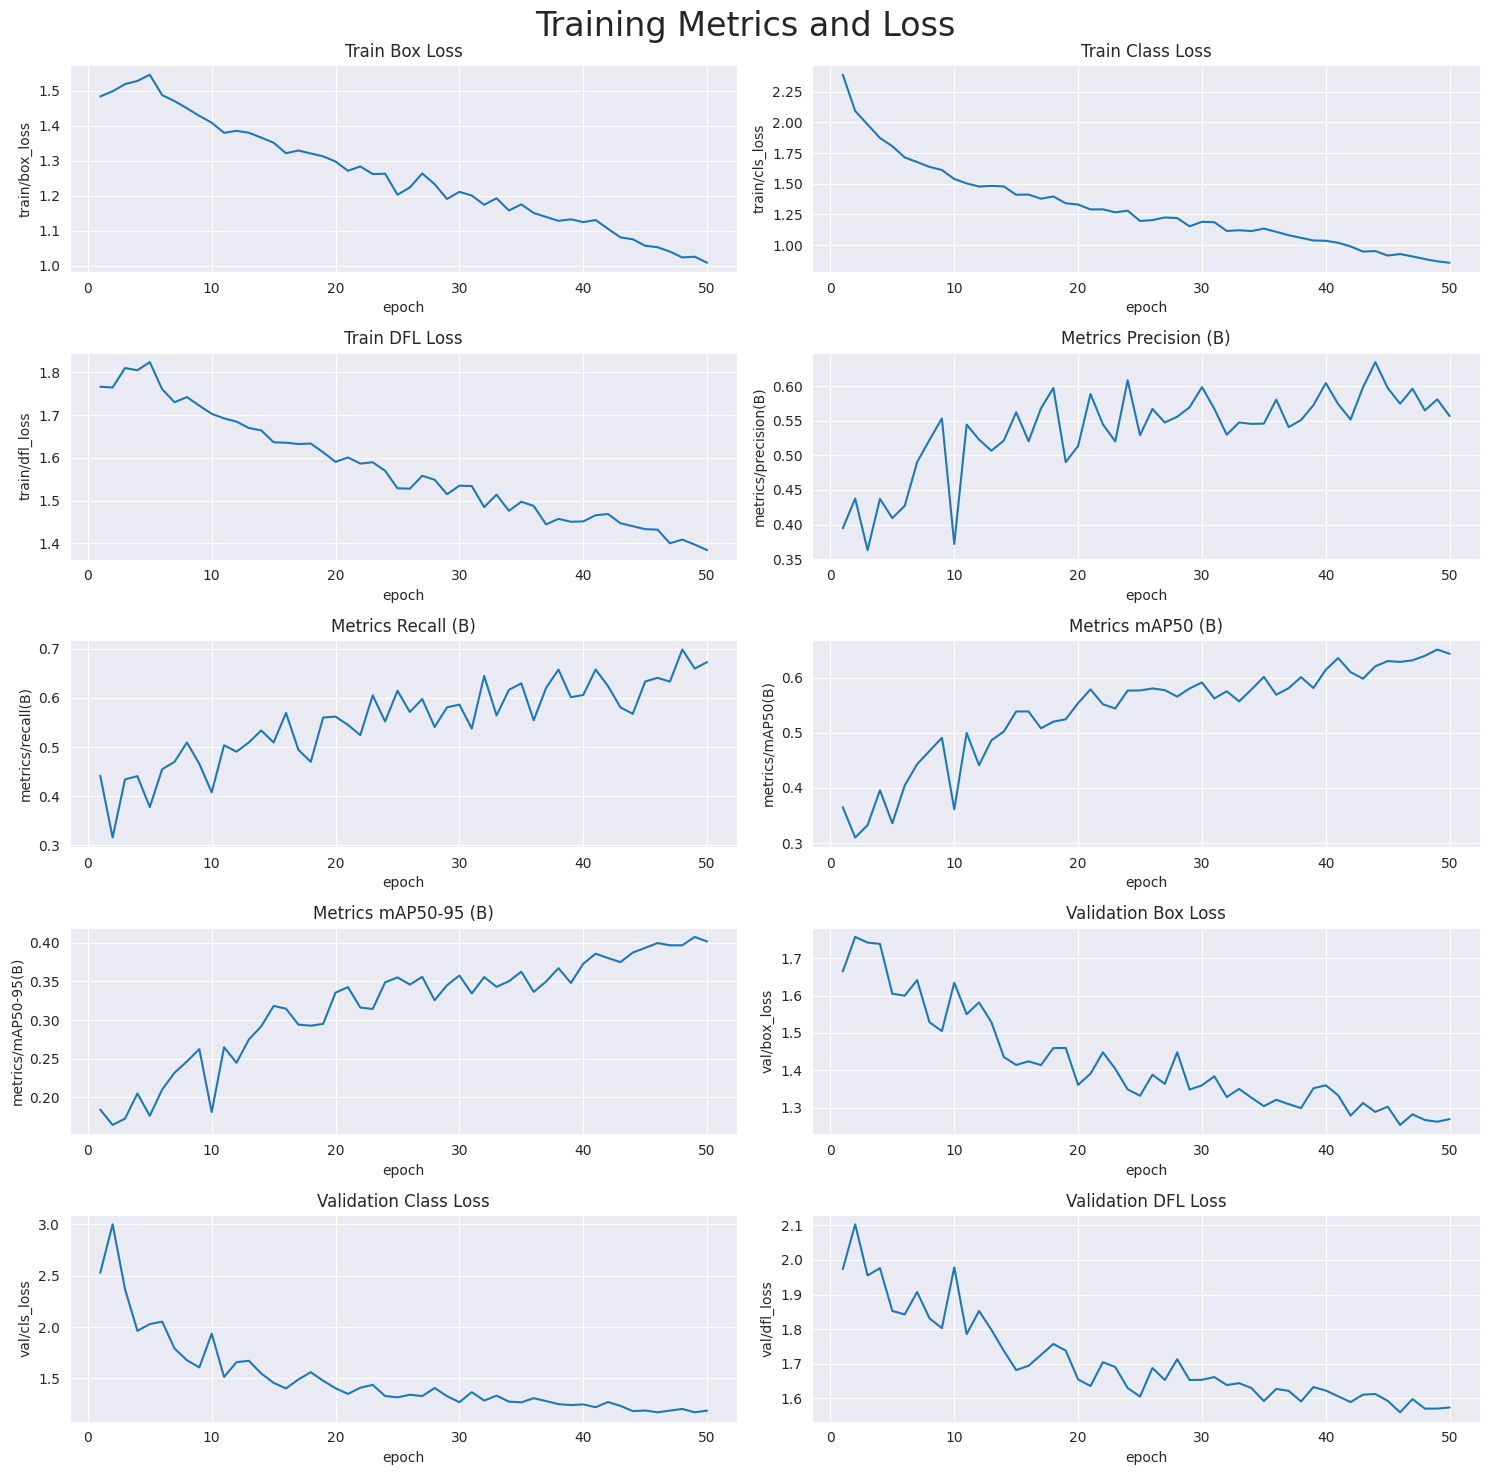

In [ ]:
csv_path = '/content/runs/detect/train/results.csv'
show_csv_results(csv_path)


0: 1024x1024 4 leafs, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 1.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 leaf, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 3 leafs, 13.0ms
Speed: 7.0ms preprocess, 13.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 leaf, 13.0ms
Speed: 7.2ms preprocess, 13.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 2 leafs, 13.0ms
Speed: 5.7ms preprocess, 13.0ms inference, 1.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 7 leafs, 13.0ms
Speed: 5.8ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 3 leafs, 13.1ms
Speed: 7.1ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 4 leafs, 13.1ms
Speed: 6.8ms preprocess, 13.1ms inference, 1.5ms postprocess per imag

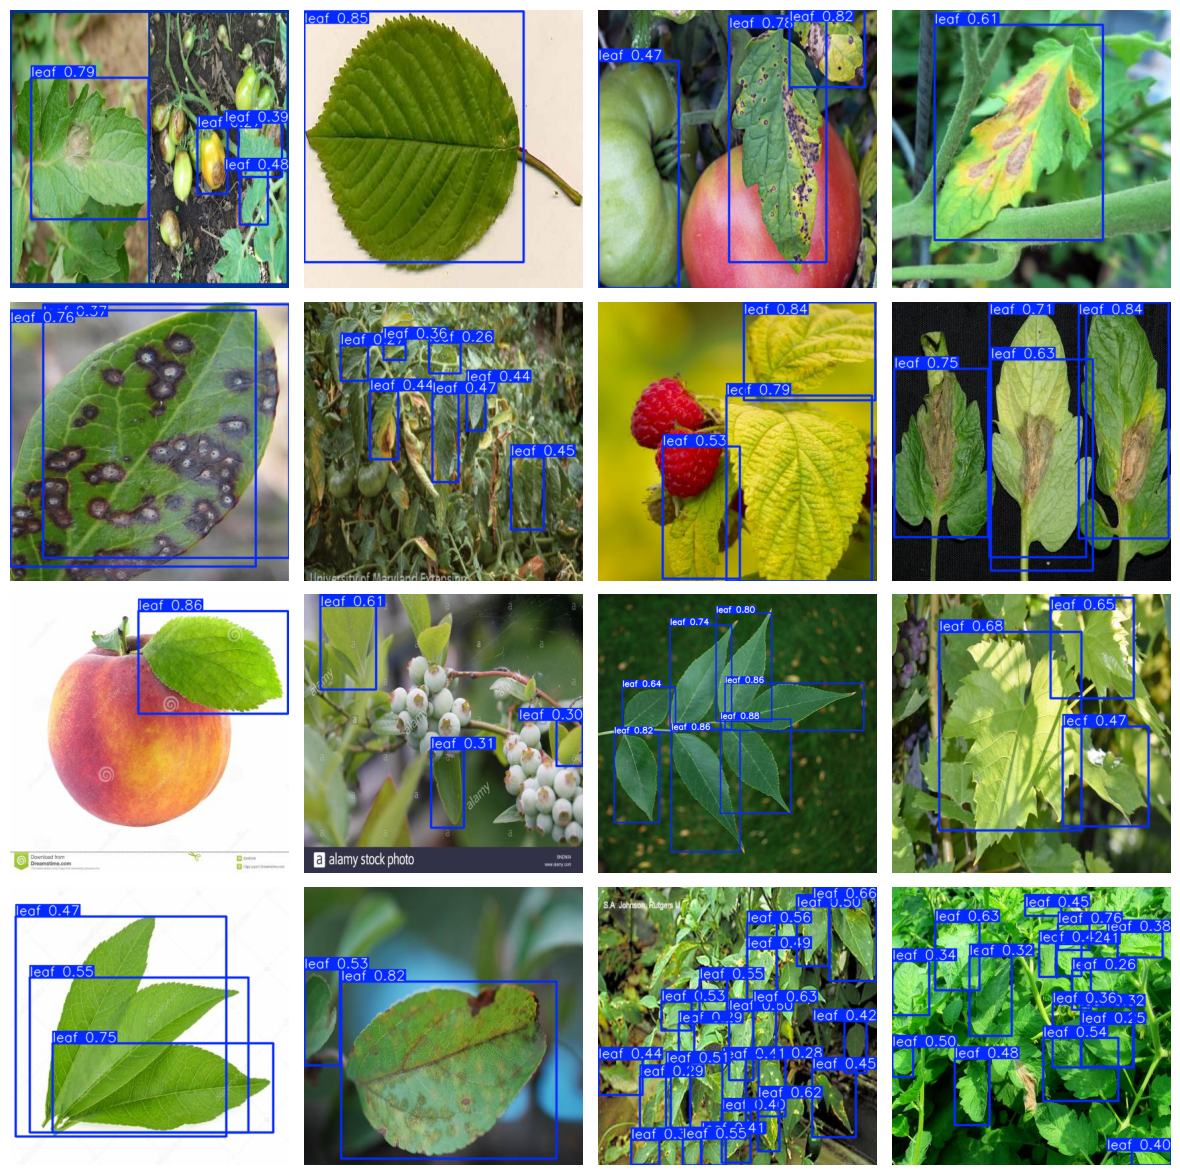

In [ ]:
# Define the directory where the custom images are stored
custom_image_dir = '/content/working/yolo_dataset_leafdetection/test/images'

# Detect and display predictions
show_detections(custom_image_dir,num_images=16, rows=4, columns=4)

In [ ]:
model.export(format='tflite')

Ultralytics 8.3.32 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) (1, 5, 21504) (6.0 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'onnx>=1.12.0', 'onnx2tf>1.17.5,<=1.22.3', 'onnxslim>=0.1.31', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.6/136.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 154.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 210.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 220.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 198.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 111.7 MB/s eta 0:

100%|██████████| 1.11M/1.11M [00:00<00:00, 27.6MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 30.88file/s]


ONNX: starting export with onnx 1.17.0 opset 19...


ONNX: slimming with onnxslim 0.1.39...
ONNX: export success ✅ 2.3s, saved as 'runs/detect/train/weights/best.onnx' (12.2 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...
TensorFlow SavedModel: export success ✅ 61.8s, saved as 'runs/detect/train/weights/best_saved_model' (30.3 MB)

TensorFlow Lite: starting export with tensorflow 2.17.1...
TensorFlow Lite: export success ✅ 0.0s, saved as 'runs/detect/train/weights/best_saved_model/best_float32.tflite' (12.0 MB)

Export complete (64.0s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=1024  
Validate:        yolo val task=detect model=runs/detect/train/weights/best_saved_model/best_float32.tflite imgsz=1024 data=/content/working/yolo_dataset_leafdetection/data.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best_saved_model/best_float32.tflite'